## Import the libraries

In [0]:
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## Read the Data

In [0]:
#Read the sample_labels.csv into a pandas dataframe
xray_df = pd.read_csv('drive/My Drive/Chest_data/sample/sample_labels.csv')
image_paths = {os.path.basename(f): f  for f in listdir("drive/My Drive/Chest_data/sample/images")   }             
print('Images found:', len(image_paths), ', Total Headers', xray_df.shape[0])
xray_df['path'] = xray_df['Image Index'].map(image_paths.get)
xray_df['Patient Age'] = xray_df['Patient Age'].map(lambda x: int(x[:-1]))
xray_df.sample(3)

OSError: ignored

In [0]:
# Since the image may contain multiple disease labels
# Create a list of all disesases and append a new column named output to the x_ray dataframe
xray_df['output']=xray_df['Finding Labels'].apply(lambda x: x.split('|'))
xray_df['Finding Labels'] = xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

In [0]:
# check if the new column has been created correctly
xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,output
2685,00013582_000.png,Fibrosis,0,13582,27,F,PA,2048,2500,0.168000,0.168000,00013582_000.png,[Fibrosis]
3089,00015192_002.png,Pleural_Thickening,2,15192,37,F,PA,2766,2901,0.143000,0.143000,00015192_002.png,[Pleural_Thickening]
3916,00019312_000.png,Atelectasis|Infiltration,0,19312,20,F,AP,3036,2544,0.139000,0.139000,00019312_000.png,"[Atelectasis, Infiltration]"
5405,00029203_001.png,Infiltration,1,29203,57,F,PA,1940,2021,0.194314,0.194314,00029203_001.png,[Infiltration]
2742,00013731_004.png,Fibrosis|Mass,4,13731,48,M,PA,2992,2991,0.143000,0.143000,00013731_004.png,"[Fibrosis, Mass]"


In [0]:
diseases=['Atelectasis','Cardiomegaly','Effusion','Infiltration','Mass','Nodule','Pneumonia','Pneumothorax','Consolidation','Edema','Emphysema','Fibrosis','Pleural Thickening','Hernia']

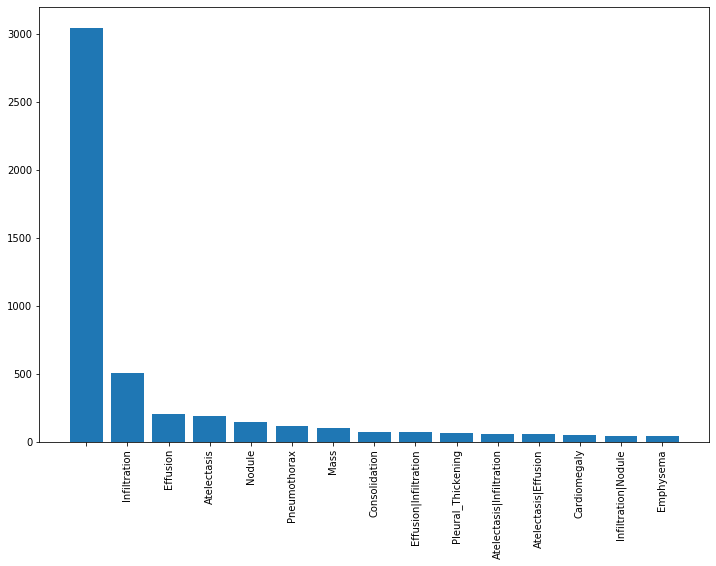

In [0]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
xray_df = xray_df.sample(5606, weights=sample_weights)

label_counts = xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

## Split the data into training and test set

In [0]:
# 20% of the data will be used for testing of model performance
# random state is set so as to get the same split everytime
# stratify is used to have equal proportion of output label in training and validation set
train_df, valid_df = train_test_split(xray_df, 
                                   test_size = 0.20, 
                                   random_state = 2018,
                                   stratify = xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 4484 validation 1122


In [0]:
IMG_SIZE = (128, 128)
#creating an Image Data generator
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15,
                              validation_split = 0.1)

In [0]:
train_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,output
231,00001256_007.png,Emphysema|Infiltration|Pleural_Thickening,7,1256,59,M,PA,2992,2991,0.143,0.143,00001256_007.png,"[Emphysema, Infiltration, Pleural_Thickening]"
3948,00019486_000.png,Cardiomegaly,0,19486,49,M,PA,2992,2991,0.143,0.143,00019486_000.png,[Cardiomegaly]
3612,00017761_001.png,,1,17761,61,F,PA,2992,2991,0.143,0.143,00017761_001.png,[]
2254,00011579_007.png,,7,11579,57,M,AP,2500,2048,0.168,0.168,00011579_007.png,[]
1275,00006713_005.png,,5,6713,72,M,AP,2500,2048,0.171,0.171,00006713_005.png,[]


In [0]:
# obtaing the training images using the above generator
train_gen = core_idg.flow_from_dataframe(
        dataframe=train_df,
        directory='drive/My Drive/Chest_data/sample/images',
        x_col='path',
        y_col='output',
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical',subset='training')

Found 4036 validated image filenames belonging to 15 classes.


In [0]:
# obtaing the validation images using the above generator
valid_gen = core_idg.flow_from_dataframe(
        dataframe=train_df,
        directory='drive/My Drive/Chest_data/sample/images',
        x_col='path',
        y_col='output',
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical',subset='validation')

Found 448 validated image filenames belonging to 15 classes.


In [0]:
# print the output classes in ImageDataGenerator train_gen
train_gen.class_indices.keys()

dict_keys(['', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'])

In [0]:
#select a batch of images used for prediction on trained model
test_X, test_Y = next(core_idg.flow_from_dataframe(
        dataframe=valid_df,
        directory='drive/My Drive/Chest_data/sample/images',
        x_col='path',
        y_col='output',
        target_size=(128, 128),
        batch_size=1024,
        class_mode='categorical')) # one big batch

Found 1122 validated image filenames belonging to 15 classes.


KeyboardInterrupt: ignored

## Model

In [0]:
# create a function to return a mobileNetModel with the output layer having 15 output units
def mobilenet_model():
  base_mobilenet_model = MobileNet(input_shape =  (128, 128, 3), include_top = False, weights = None)
  model = Sequential()
  model.add(base_mobilenet_model)
  model.add(GlobalAveragePooling2D())
  model.add(Dropout(0.5))
  model.add(Dense(512,activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(15, activation = 'sigmoid'))
  return model

In [0]:
# choose an appropriate model and compile
model=mobilenet_model()
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy', 'mae'])
# print the model details
model.summary()












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
______________________________

In [0]:
# creating a callback to store the best model
weight_path="{}_weights.best.hdf5".format('xray_class')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [0]:
# start training the model
model.fit_generator(train_gen, 
                    steps_per_epoch=100,
                    validation_data=valid_gen,
                    epochs = 5, 
                    callbacks = callbacks_list)



Epoch 1/5


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 43 could not be retrieved. It could be because a worker has died.
  UserWarning)


  2/100 [..............................] - ETA: 40:59 - loss: 0.6296 - binary_accuracy: 0.6313 - mean_absolute_error: 0.4229  

KeyboardInterrupt: ignored

In [0]:
# load the best weights
model.load_weights(weight_path)
# predict on the test_X batch of the validation set
res = model.evaluate(test_X,test_Y batch_size = 32, verbose = True)

In [0]:
print('loss = ',res[0])
print('Binary accuracy = ',res[1])
print('Mean absolute error',res[2])

In [0]:
# visualising model performance
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(diseases, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(diseases, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')